# **Homework 2 - Classification**
若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

Binary classification is one of the most fundamental problem in machine learning. In this tutorial, you are going to build linear binary classifiers to predict whether the income of an indivisual exceeds 50,000 or not. We presented a discriminative and a generative approaches, the logistic regression(LR) and the linear discriminant anaysis(LDA). You are encouraged to compare the differences between the two, or explore more methodologies. Although you can finish this tutorial by simpliy copying and pasting the codes, we strongly recommend you to understand the mathematical formulation first to get more insight into the two algorithms. Please find [here](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf) and [here](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf) for more detailed information about the two algorithms.

二元分類是機器學習中最基礎的問題之一，在這份教學中，你將學會如何實作一個線性二元分類器，來根據人們的個人資料，判斷其年收入是否高於 50,000 美元。我們將以兩種方法: logistic regression 與 generative model，來達成以上目的，你可以嘗試了解、分析兩者的設計理念及差別。針對這兩個演算法的理論基礎，可以參考李宏毅老師的教學投影片 [logistic regression](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf) 與 [generative model](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)。

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# Dataset

This dataset is obtained by removing unnecessary attributes and balancing the ratio between positively and negatively labeled data in the [**Census-Income (KDD) Data Set**](https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)), which can be found in [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/index.php). Only preprocessed and one-hot encoded data (i.e. *X_train*,  *Y_train* and *X_test*) will be used in this tutorial. Raw data (i.e. *train.csv* and *test.csv*) are provided to you in case you are interested in it.

這個資料集是由 [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/index.php) 的 [**Census-Income (KDD) Data Set**](https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)) 經過一些處理而得來。為了方便訓練，我們移除了一些不必要的資訊，並且稍微平衡了正負兩種標記的比例。事實上在訓練過程中，只有 X_train、Y_train 和 X_test 這三個經過處理的檔案會被使用到，train.csv 和 test.csv 這兩個原始資料檔則可以提供你一些額外的資訊。

# Logistic Regression

In this section we will introduce logistic regression first. We only present how to implement it here, while mathematical formulation and analysis will be omitted. You can find more theoretical detail in [Prof. Lee's lecture](https://www.youtube.com/watch?v=hSXFuypLukA).

首先我們會實作 logistic regression，針對理論細節說明請參考[李宏毅老師的教學影片](https://www.youtube.com/watch?v=hSXFuypLukA)

### Preparing Data

Load and normalize data, and then split training data into training set and development set.

下載資料，並且對每個屬性做正規化，處理過後再將其切分為訓練集與發展集。

In [1]:
import numpy as np

np.random.seed(0)
X_train_fpath = '../data/X_train'
Y_train_fpath = '../data/Y_train'
X_test_fpath = '../data/X_test'
output_fpath = '../results/output_{}.csv'

# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
    
# Split data into training set and development set
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510



### Some Useful Functions

Some functions that will be repeatedly used when iteratively updating the parameters.

這幾個函數可能會在訓練迴圈中被重複使用到。

In [2]:
def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def _sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

def _f(X, w, b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmoid(np.matmul(X, w) + b)

def _predict(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    return np.round(_f(X, w, b)).astype(np.int)
    
def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

### Functions about gradient and loss

Please refers to [Prof. Lee's lecture slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf)(p.12) for the formula of gradient and loss computation.

請參考[李宏毅老師上課投影片](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf)第 12 頁的梯度及損失函數計算公式。

In [3]:
def _cross_entropy_loss(y_pred, Y_label):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad


## Progress bar

In [4]:
def _progress_bar(
    epoch,
    max_iter,
    percentage,
    training_acc,
    training_loss,
    dev_acc,
    dev_loss,
    block = 10
):
    if percentage == 100.:
        print('\r',
              '[Epoch %d/%d]:[%s]%.1f%%' % (epoch, max_iter, '█' * block, 100.0),
              'training_acc: %.4f' % training_acc,
              'training_loss: %.4f' % training_loss,
              'dev_acc: %.4f' % dev_acc,
              'dev_loss: %.4f' % dev_loss,
              ';\n\n',
              end = '')
    else:
        print('\r',
              '[Epoch %d/%d]:[%s%s]%.1f%%' % (epoch, max_iter,
                                           '█' * int(percentage*block/100),
                                           ' ' * (block-int(percentage*block/100)),
                                           float(percentage)),
              end = '')

### Training

Everything is prepared, let's start training! 

Mini-batch gradient descent is used here, in which training data are split into several mini-batches and each batch is fed into the model sequentially for losses and gradients computation. Weights and bias are updated on a mini-batch basis.

Once we have gone through the whole training set,  the data have to be re-shuffled and mini-batch gradient desent has to be run on it again. We repeat such process until max number of iterations is reached.

我們使用小批次梯度下降法來訓練。訓練資料被分為許多小批次，針對每一個小批次，我們分別計算其梯度以及損失，並根據該批次來更新模型的參數。當一次迴圈完成，也就是整個訓練集的所有小批次都被使用過一次以後，我們將所有訓練資料打散並且重新分成新的小批次，進行下一個迴圈，直到事先設定的迴圈數量達成為止。

In [8]:
# Zero initialization for weights ans bias
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# Some parameters for training    
max_iter = 6000
batch_size = 200
learning_rate = 0.001
early_stopping_iter = 100
temp_acc = 0
temp_epoch = 0

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# Calcuate the number of parameter updates
step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_train, Y_train = _shuffle(X_train, Y_train)
    
    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)
            
        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1
        
        y_train_pred = _f(X_train, w, b)
        Y_train_pred = np.round(y_train_pred)
        T_acc = _accuracy(Y_train_pred, Y_train)
        T_loss = _cross_entropy_loss(y_train_pred, Y_train) / train_size
        
        y_dev_pred = _f(X_dev, w, b)
        Y_dev_pred = np.round(y_dev_pred)
        D_acc = _accuracy(Y_dev_pred, Y_dev)
        D_loss = _cross_entropy_loss(y_dev_pred, Y_dev) / dev_size
        
        # progress bar
        if idx == int(np.floor(train_size / batch_size)) - 1:
            _progress_bar(epoch+1, max_iter, 100., T_acc, T_loss, D_acc, D_loss)
        else:
            _progress_bar(epoch+1, max_iter, idx * batch_size * 100 / train_size, T_acc, T_loss, D_acc, D_loss)
            
    train_acc.append(T_acc)
    train_loss.append(T_loss)

    dev_acc.append(D_acc)
    dev_loss.append(D_loss)
    
    # early stopping
    if D_acc > temp_acc:
        temp_acc = np.copy(D_acc)
        temp_epoch = 0
        
        temp_w = np.copy(w)
        temp_b = np.copy(b)
        temp_step = np.copy(step)
    else:
        if temp_epoch < early_stopping_iter:
            temp_epoch += 1
        else:
            print("early stopping at epoch:", epoch - temp_epoch)
            
            train_acc[:-temp_epoch]
            train_loss[:-temp_epoch]

            dev_acc[:-temp_epoch]
            dev_loss[:-temp_epoch]
            
            w = temp_w
            b = temp_b
            step = temp_step
            break

 [Epoch 1/6000]:[██████████]100.0% training_acc: 0.8709 training_loss: 0.3411 dev_acc: 0.8614 dev_loss: 0.3501 ;

 [Epoch 2/6000]:[██████████]100.0% training_acc: 0.8759 training_loss: 0.3177 dev_acc: 0.8645 dev_loss: 0.3284 ;

 [Epoch 3/6000]:[██████████]100.0% training_acc: 0.8775 training_loss: 0.3069 dev_acc: 0.8686 dev_loss: 0.3185 ;

 [Epoch 4/6000]:[██████████]100.0% training_acc: 0.8781 training_loss: 0.3004 dev_acc: 0.8688 dev_loss: 0.3125 ;

 [Epoch 5/6000]:[██████████]100.0% training_acc: 0.8789 training_loss: 0.2959 dev_acc: 0.8701 dev_loss: 0.3085 ;

 [Epoch 6/6000]:[██████████]100.0% training_acc: 0.8796 training_loss: 0.2926 dev_acc: 0.8712 dev_loss: 0.3056 ;

 [Epoch 7/6000]:[██████████]100.0% training_acc: 0.8800 training_loss: 0.2901 dev_acc: 0.8712 dev_loss: 0.3034 ;

 [Epoch 8/6000]:[██████████]100.0% training_acc: 0.8803 training_loss: 0.2881 dev_acc: 0.8715 dev_loss: 0.3016 ;

 [Epoch 9/6000]:[██████████]100.0% training_acc: 0.8806 training_loss: 0.2864 dev_acc: 0

 [Epoch 143/6000]:[██████████]100.0% training_acc: 0.8844 training_loss: 0.2671 dev_acc: 0.8776 dev_loss: 0.2852 ;

 [Epoch 144/6000]:[██████████]100.0% training_acc: 0.8844 training_loss: 0.2671 dev_acc: 0.8776 dev_loss: 0.2852 ;

 [Epoch 145/6000]:[██████████]100.0% training_acc: 0.8844 training_loss: 0.2671 dev_acc: 0.8776 dev_loss: 0.2852 ;

 [Epoch 146/6000]:[██████████]100.0% training_acc: 0.8845 training_loss: 0.2671 dev_acc: 0.8774 dev_loss: 0.2851 ;

 [Epoch 147/6000]:[██████████]100.0% training_acc: 0.8845 training_loss: 0.2671 dev_acc: 0.8774 dev_loss: 0.2851 ;

 [Epoch 148/6000]:[██████████]100.0% training_acc: 0.8845 training_loss: 0.2671 dev_acc: 0.8773 dev_loss: 0.2851 ;

 [Epoch 149/6000]:[██████████]100.0% training_acc: 0.8844 training_loss: 0.2670 dev_acc: 0.8774 dev_loss: 0.2851 ;

 [Epoch 150/6000]:[██████████]100.0% training_acc: 0.8845 training_loss: 0.2670 dev_acc: 0.8773 dev_loss: 0.2851 ;

 [Epoch 151/6000]:[██████████]100.0% training_acc: 0.8845 training_loss:

 [Epoch 214/6000]:[██████████]100.0% training_acc: 0.8848 training_loss: 0.2662 dev_acc: 0.8784 dev_loss: 0.2845 ;

 [Epoch 215/6000]:[██████████]100.0% training_acc: 0.8849 training_loss: 0.2662 dev_acc: 0.8784 dev_loss: 0.2845 ;

 [Epoch 216/6000]:[██████████]100.0% training_acc: 0.8848 training_loss: 0.2662 dev_acc: 0.8784 dev_loss: 0.2845 ;

 [Epoch 217/6000]:[██████████]100.0% training_acc: 0.8848 training_loss: 0.2662 dev_acc: 0.8784 dev_loss: 0.2845 ;

 [Epoch 218/6000]:[██████████]100.0% training_acc: 0.8848 training_loss: 0.2662 dev_acc: 0.8784 dev_loss: 0.2845 ;

 [Epoch 219/6000]:[██████████]100.0% training_acc: 0.8848 training_loss: 0.2662 dev_acc: 0.8784 dev_loss: 0.2845 ;

 [Epoch 220/6000]:[██████████]100.0% training_acc: 0.8848 training_loss: 0.2662 dev_acc: 0.8784 dev_loss: 0.2845 ;

 [Epoch 221/6000]:[██████████]100.0% training_acc: 0.8848 training_loss: 0.2662 dev_acc: 0.8784 dev_loss: 0.2845 ;

 [Epoch 222/6000]:[██████████]100.0% training_acc: 0.8848 training_loss:

 [Epoch 285/6000]:[██████████]100.0% training_acc: 0.8851 training_loss: 0.2657 dev_acc: 0.8782 dev_loss: 0.2842 ;

 [Epoch 286/6000]:[██████████]100.0% training_acc: 0.8851 training_loss: 0.2657 dev_acc: 0.8782 dev_loss: 0.2842 ;

 [Epoch 287/6000]:[██████████]100.0% training_acc: 0.8852 training_loss: 0.2657 dev_acc: 0.8782 dev_loss: 0.2842 ;

 [Epoch 288/6000]:[██████████]100.0% training_acc: 0.8852 training_loss: 0.2657 dev_acc: 0.8782 dev_loss: 0.2842 ;

 [Epoch 289/6000]:[██████████]100.0% training_acc: 0.8852 training_loss: 0.2657 dev_acc: 0.8782 dev_loss: 0.2842 ;

 [Epoch 290/6000]:[██████████]100.0% training_acc: 0.8852 training_loss: 0.2657 dev_acc: 0.8782 dev_loss: 0.2842 ;

 [Epoch 291/6000]:[██████████]100.0% training_acc: 0.8852 training_loss: 0.2657 dev_acc: 0.8782 dev_loss: 0.2842 ;

 [Epoch 292/6000]:[██████████]100.0% training_acc: 0.8852 training_loss: 0.2657 dev_acc: 0.8780 dev_loss: 0.2842 ;

 [Epoch 293/6000]:[██████████]100.0% training_acc: 0.8852 training_loss:

 [Epoch 356/6000]:[██████████]100.0% training_acc: 0.8853 training_loss: 0.2654 dev_acc: 0.8782 dev_loss: 0.2840 ;

 [Epoch 357/6000]:[██████████]100.0% training_acc: 0.8852 training_loss: 0.2654 dev_acc: 0.8782 dev_loss: 0.2840 ;

 [Epoch 358/6000]:[██████████]100.0% training_acc: 0.8853 training_loss: 0.2654 dev_acc: 0.8782 dev_loss: 0.2840 ;

 [Epoch 359/6000]:[██████████]100.0% training_acc: 0.8853 training_loss: 0.2654 dev_acc: 0.8782 dev_loss: 0.2840 ;

 [Epoch 360/6000]:[██████████]100.0% training_acc: 0.8853 training_loss: 0.2654 dev_acc: 0.8782 dev_loss: 0.2840 ;

 [Epoch 361/6000]:[██████████]100.0% training_acc: 0.8853 training_loss: 0.2654 dev_acc: 0.8782 dev_loss: 0.2840 ;

 [Epoch 362/6000]:[██████████]100.0% training_acc: 0.8853 training_loss: 0.2654 dev_acc: 0.8782 dev_loss: 0.2840 ;

 [Epoch 363/6000]:[██████████]100.0% training_acc: 0.8853 training_loss: 0.2654 dev_acc: 0.8782 dev_loss: 0.2840 ;

 [Epoch 364/6000]:[██████████]100.0% training_acc: 0.8853 training_loss:

 [Epoch 427/6000]:[██████████]100.0% training_acc: 0.8855 training_loss: 0.2652 dev_acc: 0.8784 dev_loss: 0.2839 ;

 [Epoch 428/6000]:[██████████]100.0% training_acc: 0.8855 training_loss: 0.2652 dev_acc: 0.8784 dev_loss: 0.2839 ;

 [Epoch 429/6000]:[██████████]100.0% training_acc: 0.8855 training_loss: 0.2652 dev_acc: 0.8784 dev_loss: 0.2839 ;

 [Epoch 430/6000]:[██████████]100.0% training_acc: 0.8855 training_loss: 0.2652 dev_acc: 0.8784 dev_loss: 0.2839 ;

 [Epoch 431/6000]:[██████████]100.0% training_acc: 0.8855 training_loss: 0.2651 dev_acc: 0.8784 dev_loss: 0.2839 ;

 [Epoch 432/6000]:[██████████]100.0% training_acc: 0.8855 training_loss: 0.2651 dev_acc: 0.8784 dev_loss: 0.2839 ;

 [Epoch 433/6000]:[██████████]100.0% training_acc: 0.8855 training_loss: 0.2651 dev_acc: 0.8782 dev_loss: 0.2839 ;

 [Epoch 434/6000]:[██████████]100.0% training_acc: 0.8855 training_loss: 0.2651 dev_acc: 0.8782 dev_loss: 0.2839 ;

 [Epoch 435/6000]:[██████████]100.0% training_acc: 0.8856 training_loss:

 [Epoch 498/6000]:[██████████]100.0% training_acc: 0.8855 training_loss: 0.2650 dev_acc: 0.8780 dev_loss: 0.2838 ;

 [Epoch 499/6000]:[██████████]100.0% training_acc: 0.8856 training_loss: 0.2650 dev_acc: 0.8780 dev_loss: 0.2838 ;

 [Epoch 500/6000]:[██████████]100.0% training_acc: 0.8856 training_loss: 0.2650 dev_acc: 0.8780 dev_loss: 0.2838 ;

 [Epoch 501/6000]:[█████████ ]99.1%[Epoch 501/6000]:[█         ]16.8%[Epoch 501/6000]:[████████  ]88.9%[Epoch 501/6000]:[██████████]100.0% training_acc: 0.8856 training_loss: 0.2650 dev_acc: 0.8780 dev_loss: 0.2838 ;

 [Epoch 502/6000]:[██████████]100.0% training_acc: 0.8856 training_loss: 0.2650 dev_acc: 0.8780 dev_loss: 0.2838 ;

 [Epoch 503/6000]:[██████████]100.0% training_acc: 0.8856 training_loss: 0.2650 dev_acc: 0.8780 dev_loss: 0.2838 ;

 [Epoch 504/6000]:[██████████]100.0% training_acc: 0.8855 training_loss: 0.2650 dev_acc: 0.8780 dev_loss: 0.2838 ;

 [Epoch 505/6000]:[██████████]100.0% training_acc: 0.8855 training_loss: 0.2650 dev_ac

 [Epoch 568/6000]:[██████████]100.0% training_acc: 0.8858 training_loss: 0.2649 dev_acc: 0.8782 dev_loss: 0.2837 ;

 [Epoch 569/6000]:[██████████]100.0% training_acc: 0.8858 training_loss: 0.2649 dev_acc: 0.8782 dev_loss: 0.2837 ;

 [Epoch 570/6000]:[██████████]100.0% training_acc: 0.8857 training_loss: 0.2649 dev_acc: 0.8782 dev_loss: 0.2837 ;

 [Epoch 571/6000]:[██████████]100.0% training_acc: 0.8857 training_loss: 0.2649 dev_acc: 0.8782 dev_loss: 0.2837 ;

 [Epoch 572/6000]:[██████████]100.0% training_acc: 0.8857 training_loss: 0.2649 dev_acc: 0.8782 dev_loss: 0.2837 ;

 [Epoch 573/6000]:[██████████]100.0% training_acc: 0.8858 training_loss: 0.2649 dev_acc: 0.8782 dev_loss: 0.2837 ;

 [Epoch 574/6000]:[██████████]100.0% training_acc: 0.8858 training_loss: 0.2649 dev_acc: 0.8782 dev_loss: 0.2837 ;

 [Epoch 575/6000]:[██████████]100.0% training_acc: 0.8857 training_loss: 0.2649 dev_acc: 0.8782 dev_loss: 0.2837 ;

 [Epoch 576/6000]:[██████████]100.0% training_acc: 0.8857 training_loss:

 [Epoch 709/6000]:[██████████]100.0% training_acc: 0.8858 training_loss: 0.2647 dev_acc: 0.8784 dev_loss: 0.2836 ;

 [Epoch 710/6000]:[██████████]100.0% training_acc: 0.8858 training_loss: 0.2647 dev_acc: 0.8784 dev_loss: 0.2836 ;

 [Epoch 711/6000]:[██████████]100.0% training_acc: 0.8858 training_loss: 0.2647 dev_acc: 0.8784 dev_loss: 0.2836 ;

 [Epoch 712/6000]:[██████████]100.0% training_acc: 0.8858 training_loss: 0.2647 dev_acc: 0.8784 dev_loss: 0.2836 ;

 [Epoch 713/6000]:[██████████]100.0% training_acc: 0.8858 training_loss: 0.2647 dev_acc: 0.8784 dev_loss: 0.2836 ;

 [Epoch 714/6000]:[██████████]100.0% training_acc: 0.8858 training_loss: 0.2647 dev_acc: 0.8784 dev_loss: 0.2836 ;

 [Epoch 715/6000]:[██████████]100.0% training_acc: 0.8858 training_loss: 0.2647 dev_acc: 0.8784 dev_loss: 0.2836 ;

 [Epoch 716/6000]:[██████████]100.0% training_acc: 0.8858 training_loss: 0.2647 dev_acc: 0.8784 dev_loss: 0.2836 ;

 [Epoch 717/6000]:[██████████]100.0% training_acc: 0.8858 training_loss:

### Plotting Loss and accuracy curve

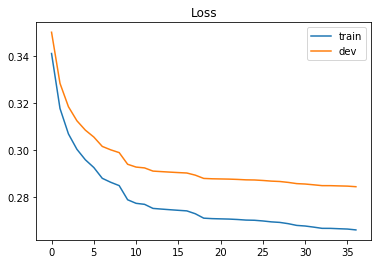

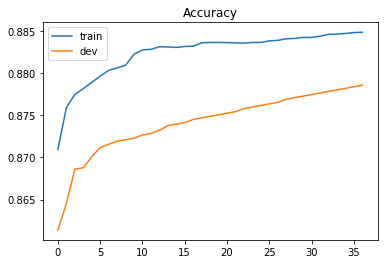

In [11]:
import matplotlib.pyplot as plt


# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('./../fig/loss.png')
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('./../fig/acc.png')
plt.show()

### Predicting testing labels

Predictions are saved to *output_logistic.csv*.

預測測試集的資料標籤並且存在 *output_logistic.csv* 中。

In [10]:
# Predict testing labels
predictions = _predict(X_test, w, b)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Unemployed full-time 0.835982593576664
capital losses 0.6137164904353742
 1 0.5063627375046139
id 0.4470052253367102
 Yes 0.35539739745685195
 Some college but no degree 0.30177353658305733
 All other 0.2577995720154868
 Male -0.2577995720154867
 5th or 6th grade 0.22515586325499992
 11th grade 0.2247349599815066
